Introduction: 
As A/B testing is imperative to effective marketing campaigns, the dataset provided shows the effect of 2 given advertisement types (Ads or Public Service Announcements). 

In [1]:
!pip install scikit-posthocs

In [4]:
import numpy as np 
import pandas as pd 
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
import seaborn as sns
import matplotlib as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
 


In [3]:
df = pd.read_csv(r"C:\Users\Austin Noriega\Downloads\marketing_AB.csv", index_col=0)
df['converted']= df['converted'].astype(int)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


In [4]:
df.describe()

,user id,converted,total ads,most ads hour
count,5.881010e+05,588101.000000,588101.000000,588101.000000
mean,1.310692e+06,0.025239,24.820876,14.469061
std,2.022260e+05,0.156850,43.715181,4.834634
min,9.000000e+05,0.000000,1.000000,0.000000
25%,1.143190e+06,0.000000,4.000000,11.000000
50%,1.313725e+06,0.000000,13.000000,14.000000
75%,1.484088e+06,0.000000,27.000000,18.000000
max,1.654483e+06,1.000000,2065.000000,23.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  int32 
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: int32(1), int64(3), object(2)
memory usage: 29.2+ MB


In [6]:
df.isna().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

In [7]:
#checking for conversion rates and lift

conversion_sum = df.groupby('test group')['converted'].agg(['sum', 'mean', 'count'])
conversion_sum['conversion_rate'] = (conversion_sum['sum']/conversion_sum['count'])*100

ad_conversion_rate = conversion_sum.loc['ad', 'conversion_rate']
psa_conversion_rate = conversion_sum.loc['psa', 'conversion_rate']
lift = format(((ad_conversion_rate-psa_conversion_rate)/psa_conversion_rate), ".0%")
print(conversion_sum, '\n\n\nAd lift rate relative to psa: ', lift)

              sum      mean   count  conversion_rate
test group                                          
ad          14423  0.025547  564577         2.554656
psa           420  0.017854   23524         1.785411 


Ad lift rate relative to psa:  43%


<Axes: xlabel='test group', ylabel='conversion_rate'>

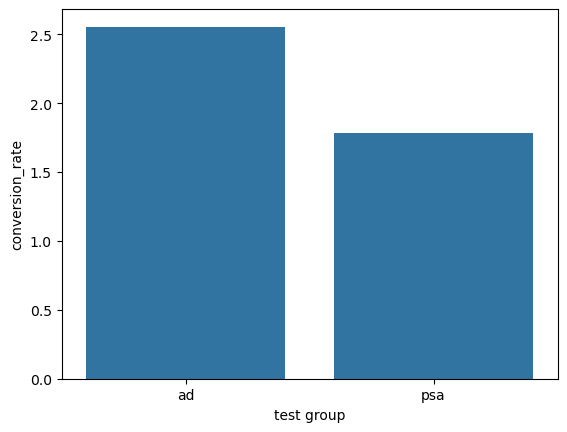

In [8]:
sns.barplot(x=conversion_sum.index, y=conversion_sum['conversion_rate'])

In [9]:
#using t-test and ANOVA and scheffe to find the importance of what users are shown and when 

psa_group = df[df['test group']=='psa']['converted']
ads_group = df[df['test group']=='ad']['converted']

t_value, p_value = ttest_ind(ads_group, psa_group, equal_var=False)
print('\033[1mT-test results: \033[0m', '\nT-value: ', t_value, '\nP-value: ', p_value, '\nAdvertisments \033[1m do \033[0m have a higher conversion rate statistically')

T-test results:  
T-value:  8.657162314551679 
P-value:  5.107607598758945e-18 
Advertisments  do  have a higher conversion rate statistically


In [10]:
anova_groups = [df[df['most ads day'] == day]['total ads'] for day in df['most ads day'].unique()]

f_stat, p_value_anova= f_oneway(*anova_groups)
print("\nANOVA Results:")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_value_anova:.4e}")
print('There is a significance in the days of the week and when ads are played')
scheffe=sp.posthoc_scheffe(df, val_col='total ads', group_col='most ads day')

def highlight(p):
    sig = p<0.05
    return ['background-color: darkgreen' if v else '' for v in sig]

scheffe.style.apply(highlight, axis=0)


ANOVA Results:
F-Statistic: 50.3731
P-Value: 2.8155e-62
There is a significance in the days of the week and when ads are played


,Monday,Tuesday,Friday,Saturday,Wednesday,Sunday,Thursday
Monday,1.000000,0.000000,0.000001,0.999784,0.033431,0.003677,0.000000
Tuesday,0.000000,1.000000,0.000000,0.000004,0.252731,0.561474,0.521759
Friday,0.000001,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Saturday,0.999784,0.000004,0.000000,1.000000,0.121120,0.021554,0.000000
Wednesday,0.033431,0.252731,0.000000,0.121120,1.000000,0.998855,0.000184
Sunday,0.003677,0.561474,0.000000,0.021554,0.998855,1.000000,0.001883
Thursday,0.000000,0.521759,0.000000,0.000000,0.000184,0.001883,1.000000


In [11]:
print('In order to test how the days of the week are related to each other, a Tukey HSD test will be used.')

tukey_results = pairwise_tukeyhsd(endog = df['total ads'], groups=df['most ads day'], alpha=0.05)
print(tukey_results)
print('Some of the main compairsions are as follows: \nFriday shows more ads than any other day \nMonday shows more ads than Sunday, Thursday, Tuesday, and Wednesday \nSaturday shows more ads than Sunday, Thursday, Tuesday, and Wednesday \nSunday shows more ads than Thursday \nAnd Thursday shows more ads than Wednesday')

In order to test how the days of the week are related to each other, a Tukey HSD test will be used.
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
  Friday    Monday  -1.2836    0.0 -1.8919 -0.6754   True
  Friday  Saturday  -1.3845    0.0  -2.003 -0.7659   True
  Friday    Sunday  -2.2085    0.0 -2.8198 -1.5971   True
  Friday  Thursday  -3.1833    0.0 -3.7992 -2.5673   True
  Friday   Tuesday  -2.6867    0.0  -3.314 -2.0593   True
  Friday Wednesday  -2.0729    0.0  -2.693 -1.4528   True
  Monday  Saturday  -0.1009 0.9992 -0.7286  0.5268  False
  Monday    Sunday  -0.9249 0.0002 -1.5454 -0.3043   True
  Monday  Thursday  -1.8997    0.0 -2.5248 -1.2746   True
  Monday   Tuesday  -1.4031    0.0 -2.0394 -0.7667   True
  Monday Wednesday  -0.7893 0.0041 -1.4185 -0.1601   True
Saturday    Sunday   -0.824 0.0023 -1.4547 -0.1933   True
Saturday  Thursday  -1.7988   

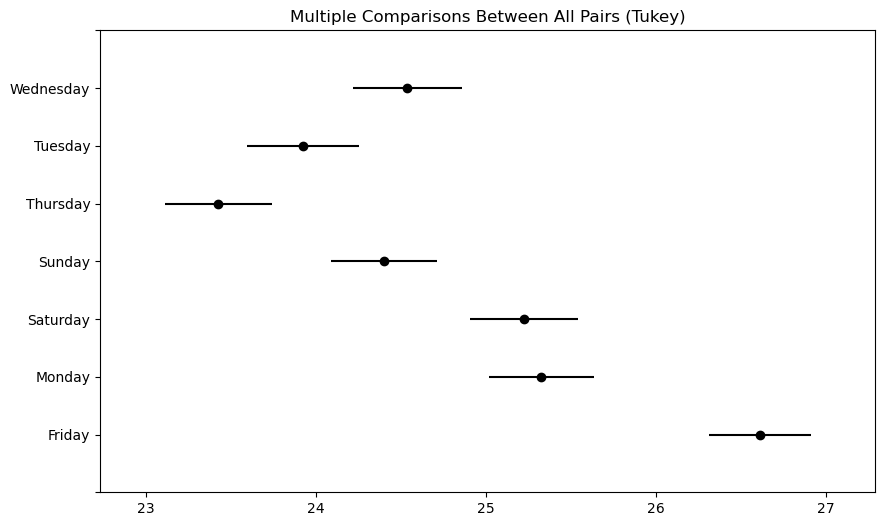

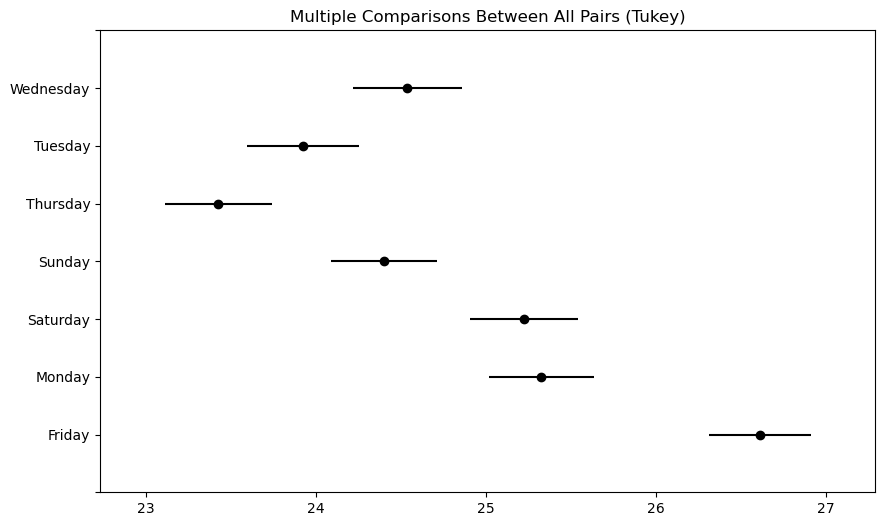

In [12]:
tukey_results.plot_simultaneous()

In [38]:
print('Now it is time to look at the main difference in how the conversions happen via chi^2 test')

contingency_table = pd.crosstab(df['converted'], df['test group'])
contingency_table

chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print('Chi2 = ', chi2, '\nP_chi2 = ', p_chi2, '\nDegrees of Freedom = ', dof, '\nIt looks like there is a sizable amount of significance in regards to which test type can convert more consumers')

Now it is time to look at the main difference in how the conversions happen via chi^2 test
Chi2 =  54.005823883685245 
P_chi2 =  1.9989623063390075e-13 
Degrees of Freedom =  1 
It looks like there is a sizable amount of significance in regards to which test type can convert more consumers


Conclusion: 
There is a bunch of significant insights that can be obtained from this research, such as:
- There is a statistically significant difference with the type of conversion method used, leaning towards the higher conversion rate with Ads (2.56%)
- Days of the week show consumers a different amount of ads, with Friday being the highest ad count people watch

Further research can be conducted to find if the amount of advertisements watched are significant to conversion rates, and how the conversion rates can fit to the overall marketing budget for future campaigns.